<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240129_podem03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [1]:
%%capture

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [2]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.2.0'

In [3]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [57]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/dbpodem_20240130.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1902 non-null   object        
 1   issuance_date     1902 non-null   datetime64[ns]
 2   issuance_year     1902 non-null   int64         
 3   issuance_week     1902 non-null   int64         
 4   dayfrac           1902 non-null   int64         
 5   eid_weeks         1902 non-null   int64         
 6   srbi_issuance     1902 non-null   int64         
 7   vix_indicator     1902 non-null   int64         
 8   bi_covid          1902 non-null   int64         
 9   gso_issuance      1902 non-null   int64         
 10  investment_grade  1902 non-null   int64         
 11  incoming_bid      1902 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 178.4+ KB


In [5]:
df_train00['issued_series'].value_counts()

sun10    293
sun20    288
spn12    273
sun15    273
sun05    267
spn03    239
sun30    171
spn09     76
sun07     11
sun08      8
sun04      1
vr04       1
sun02      1
Name: issued_series, dtype: int64

In [6]:
df_train00.describe()

,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1902.000000,1.902000e+03
mean,2017.164038,24.586225,3793.650368,0.083596,0.033649,0.082019,0.248160,0.022608,0.860673,6.264556e+06
std,4.285867,14.079532,3300.782126,0.276854,0.180371,0.274466,0.432059,0.148689,0.346379,5.916823e+06
min,2009.000000,1.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014.000000,12.000000,366.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.372000e+06
50%,2018.000000,24.000000,3631.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.402500e+06
75%,2021.000000,37.000000,5747.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000e+06
max,2024.000000,51.000000,11196.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

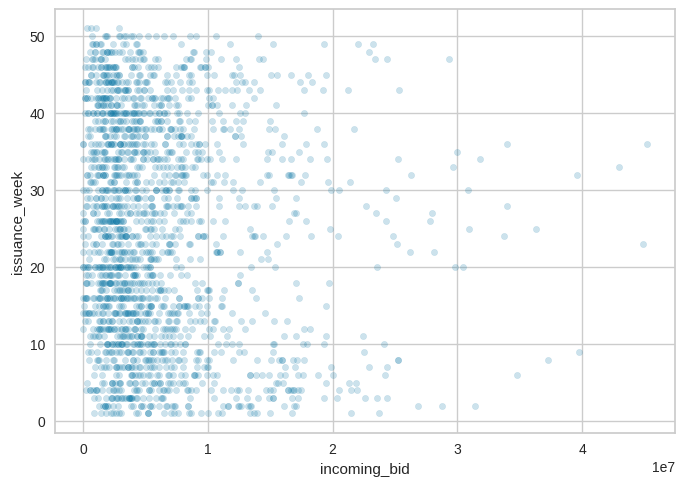

In [7]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

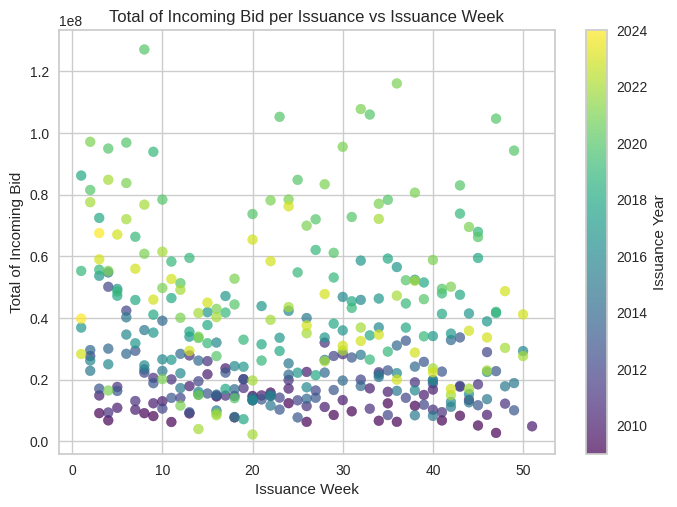

In [8]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

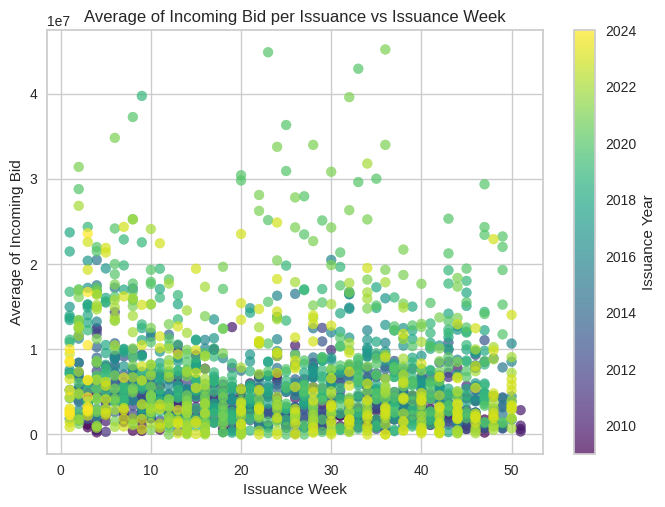

In [9]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [10]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

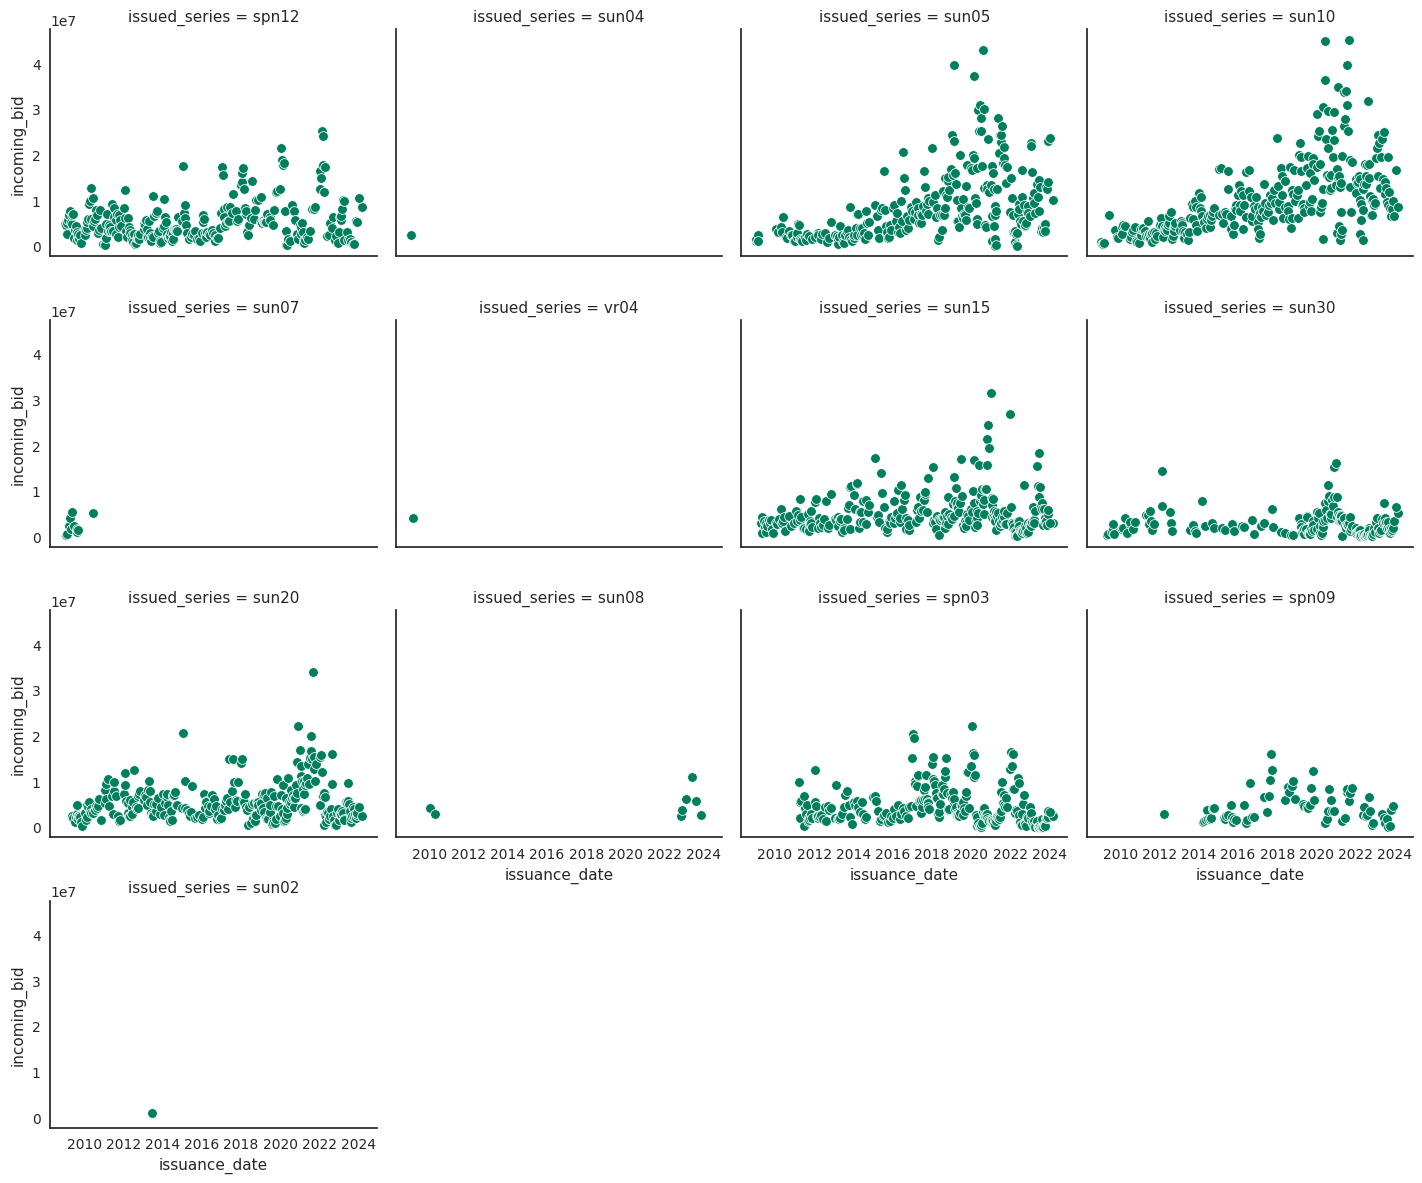

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [12]:
corr_matrix = df_train00.corr()
corr_matrix['incoming_bid'].sort_values(ascending=False)

incoming_bid        1.000000
issuance_year       0.248834
investment_grade    0.193162
bi_covid            0.177643
eid_weeks          -0.010772
srbi_issuance      -0.032493
vix_indicator      -0.049004
issuance_week      -0.095991
gso_issuance       -0.100655
dayfrac            -0.101893
Name: incoming_bid, dtype: float64

In [13]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

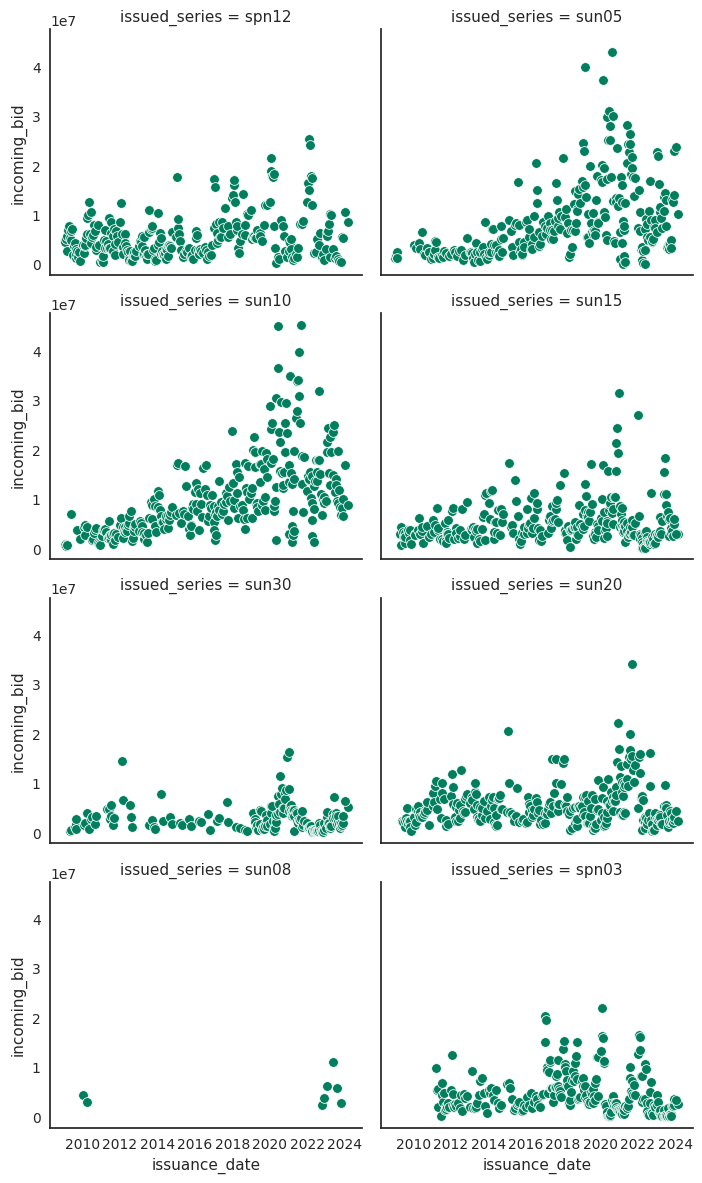

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [15]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

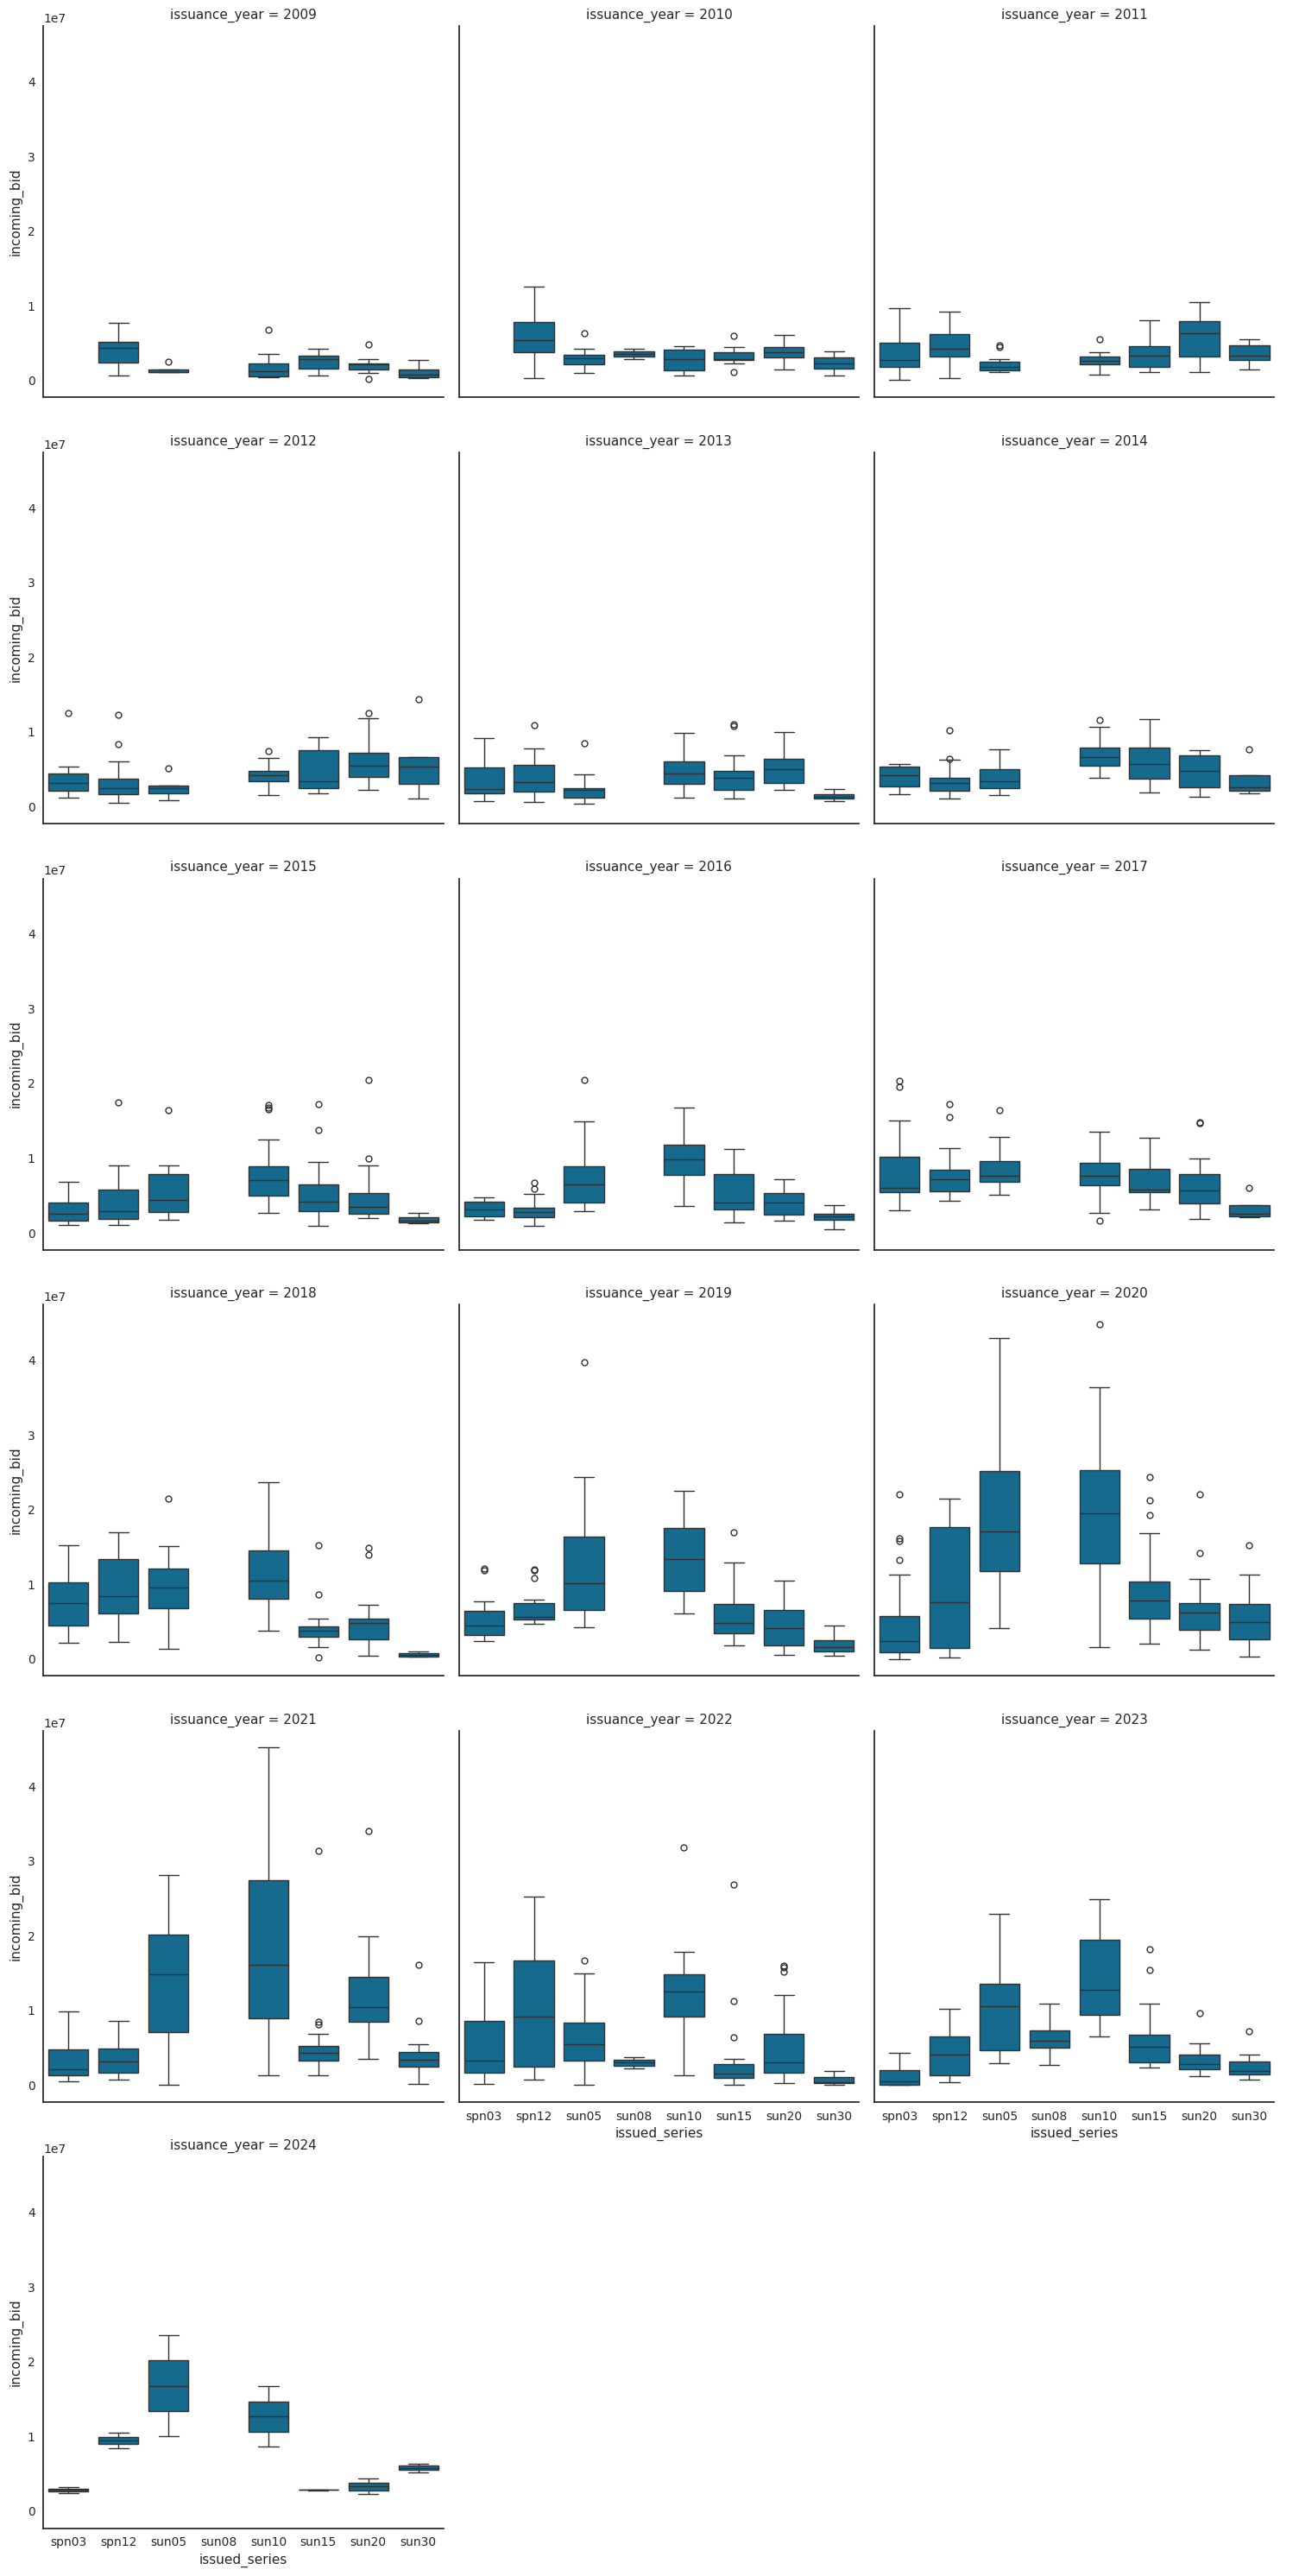

In [16]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [17]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [18]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1630, 12)
Test set shape: (182, 12)


In [20]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
sun10    263
sun20    259
spn12    246
sun15    246
sun05    240
spn03    215
sun30    154
sun08      7
Name: issued_series, dtype: int64 

Test: 
sun10    30
sun20    29
sun15    27
spn12    27
sun05    27
spn03    24
sun30    17
sun08     1
Name: issued_series, dtype: int64


In [21]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, dayfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [22]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, dayfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [23]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1812, 12)"
4,Transformed data shape,"(1812, 18)"
5,Transformed train set shape,"(1630, 18)"
6,Transformed test set shape,"(182, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [24]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2369805.4647,12701618796924.1934,3551539.1639,0.6485,1.1490,0.8043,0.5450
lightgbm,Light Gradient Boosting Machine,2449667.6811,13093523158945.8867,3604665.9575,0.6380,1.2154,1.0048,0.1710
rf,Random Forest Regressor,2460898.6979,13536184446010.3926,3665760.1856,0.6265,1.2197,1.0226,0.4770
xgboost,Extreme Gradient Boosting,2510000.5750,14422430869094.4004,3781706.0250,0.6006,1.2548,0.8984,0.1300
gbr,Gradient Boosting Regressor,2938636.3297,17983814516550.9688,4223334.1610,0.5042,1.3139,1.1870,0.1850
dt,Decision Tree Regressor,3014599.8160,23216959857487.7305,4806259.0089,0.3481,1.1796,1.0628,0.0620
llar,Lasso Least Angle Regression,3688335.6713,26591258838172.1836,5137535.3069,0.2681,1.5168,2.4255,0.1080
lasso,Lasso Regression,3690932.0062,26607426859601.8320,5139106.5214,0.2677,1.5159,2.4264,0.0800
ridge,Ridge Regression,3683943.3613,26610086254925.6953,5139198.3223,0.2677,1.5056,2.4282,0.0600
lr,Linear Regression,3691358.0044,26608531435315.3711,5139215.7582,0.2677,1.5196,2.4266,0.5480


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2196491.6425,10889772056085.5859,3299965.4629,0.6411,0.6431,0.7298
1,2465300.3529,10819130612571.2949,3289244.6872,0.7169,1.6551,0.8666
2,2337218.4905,11137500014754.3945,3337289.3214,0.6330,1.3125,0.6577
3,2529738.8334,15287968868823.6191,3909983.2313,0.6777,1.6351,0.7006
4,2694307.0007,15492992466520.9668,3936113.8788,0.6633,0.9379,3.1297
5,2395392.5305,10505576778958.4688,3241230.7506,0.6329,0.6634,0.7769
6,2600293.2320,17856281295012.7578,4225669.3310,0.6141,1.2972,0.9312
7,2319581.0476,13692453432628.1426,3700331.5301,0.5302,1.5306,0.5908
8,2453239.0218,12654264459693.2734,3557283.2976,0.6446,1.7730,0.7446


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

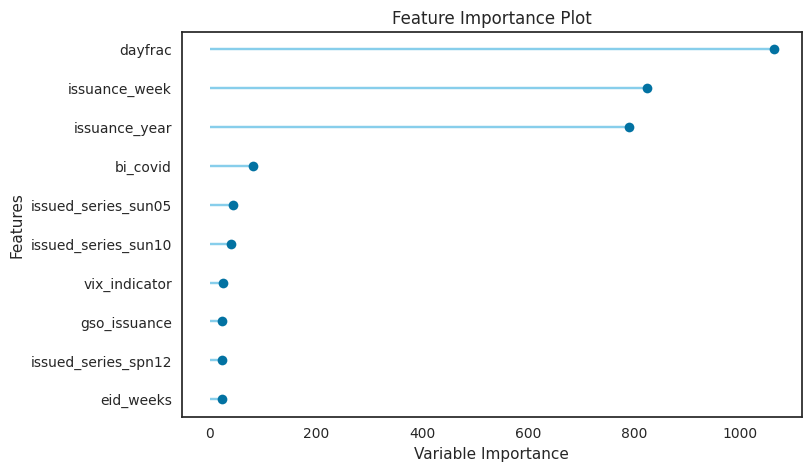

In [25]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2278089.5000,10898410307584.0000,3301274.0000,0.6408,0.6850,0.7188
1,2395753.2500,12772455743488.0000,3573857.2500,0.6657,1.7580,0.8153
2,2564354.2500,12190485577728.0000,3491487.5000,0.5983,1.4630,0.6981
3,2525701.2500,16122758823936.0000,4015315.5000,0.6601,1.6108,0.6370
4,2856388.7500,20901296865280.0000,4571793.5000,0.5457,0.9391,2.4143
5,2533035.5000,12800677117952.0000,3577803.5000,0.5527,0.6760,0.7972
6,2486416.7500,16103091732480.0000,4012865.7500,0.6520,1.1345,0.6387
7,2430103.2500,15664724049920.0000,3957868.5000,0.4625,1.6434,0.6199
8,2593159.7500,14065448517632.0000,3750393.0000,0.6049,1.8402,0.7324


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

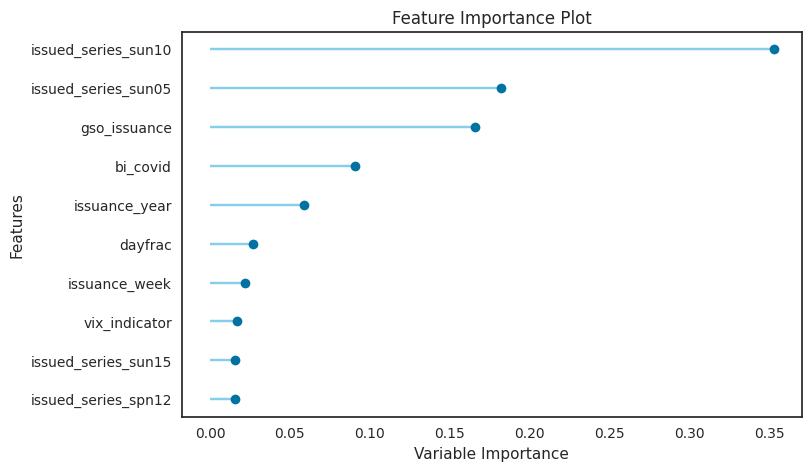

In [26]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2243239.5245,10605799364208.7246,3256654.6277,0.6505,0.5782,0.5778
1,2439887.6810,12755183464570.7207,3571439.9707,0.6662,1.5119,0.7406
2,2123555.3374,9928068226984.2305,3150883.7216,0.6728,1.1021,0.4737
3,2509039.7331,15830162449053.2773,3978713.6676,0.6663,1.6373,0.6039
4,2497370.5276,15818333095483.7305,3977226.8097,0.6562,0.8170,2.0845
5,2229319.1043,9693776839820.8105,3113483.0720,0.6613,0.6172,0.6767
6,2478166.9693,13930248351761.5957,3732324.7918,0.6990,1.2443,0.6800
7,2375652.4509,13967140729953.9316,3737263.8026,0.5208,1.6575,0.5963
8,2428696.6871,11871365458406.9453,3445484.7929,0.6666,1.6669,0.6408


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

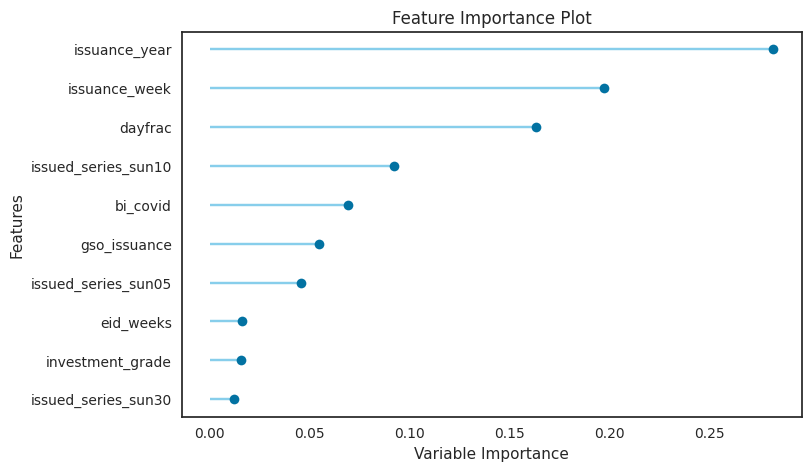

In [27]:
plot_model(create_model('et'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 63.80%

In [28]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2196491.6425,10889772056085.5859,3299965.4629,0.6411,0.6431,0.7298
1,2465300.3529,10819130612571.2949,3289244.6872,0.7169,1.6551,0.8666
2,2337218.4905,11137500014754.3945,3337289.3214,0.6330,1.3125,0.6577
3,2529738.8334,15287968868823.6191,3909983.2313,0.6777,1.6351,0.7006
4,2694307.0007,15492992466520.9668,3936113.8788,0.6633,0.9379,3.1297
5,2395392.5305,10505576778958.4688,3241230.7506,0.6329,0.6634,0.7769
6,2600293.2320,17856281295012.7578,4225669.3310,0.6141,1.2972,0.9312
7,2319581.0476,13692453432628.1426,3700331.5301,0.5302,1.5306,0.5908
8,2453239.0218,12654264459693.2734,3557283.2976,0.6446,1.7730,0.7446


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.05%

In [29]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2402092.6886,13409584178526.2402,3661909.9086,0.5581,0.7647,0.7272
1,2702646.0655,13387915239107.5391,3658950.0187,0.6496,1.5787,0.9849
2,2649088.8997,13663915564083.2422,3696473.3956,0.5497,1.4690,0.8357
3,2695129.6417,17149200417097.5684,4141159.3083,0.6385,1.6467,0.7929
4,3061636.3865,18191447212484.4492,4265143.2816,0.6046,1.0785,5.6169
5,2655878.0384,13354396586967.4082,3654366.7833,0.5334,0.7345,0.8450
6,2721452.0007,19171341273882.8750,4378509.0241,0.5857,1.3267,1.0894
7,2666281.9379,15730461785955.9863,3966164.6191,0.4603,1.7202,0.8122
8,2761622.2742,16027850590183.3320,4003479.8101,0.5498,1.7416,0.8443


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 64.27%

In [30]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2066062.1384,9778855110291.6543,3127116.1012,0.6777,0.6841,0.6827
1,2525521.4407,11511768269305.5742,3392899.6845,0.6987,1.6039,0.8665
2,2476548.1308,13025998215228.6895,3609154.7785,0.5707,1.3710,0.7573
3,2505676.8430,14668684293161.2793,3829971.8397,0.6908,1.6047,0.6546
4,2685413.0892,15874286839425.5898,3984254.8663,0.6550,0.9303,1.9894
5,2268104.0216,9516422469828.7305,3084869.9275,0.6675,0.6465,0.6947
6,2504197.6482,15748255310825.4473,3968407.1503,0.6597,1.2679,0.7047
7,2356427.8647,13622982921912.0059,3690932.5274,0.5326,1.6283,0.6188
8,2418518.4482,12799490991184.0176,3577637.6271,0.6405,1.7998,0.6939


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


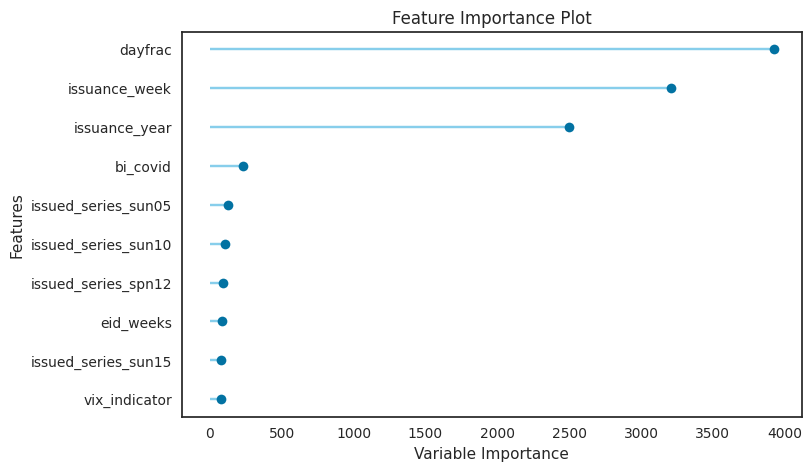

In [31]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 62.47%

In [32]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2180822.5095,10741728648458.1836,3277457.6501,0.6460,0.6427,0.7445
1,2599999.6472,12399425109953.0664,3521281.7425,0.6755,1.7246,0.9186
2,2495205.7784,12164580682851.2031,3487775.8934,0.5991,1.3317,0.6992
3,2543804.0020,15768599493713.3535,3970969.5911,0.6676,1.6387,0.7178
4,2736626.9710,15649926869504.2598,3955998.8460,0.6599,0.8948,2.4457
5,2416035.0986,10623777029016.1348,3259413.6020,0.6288,0.6666,0.7834
6,2737037.1005,19158117039001.8633,4376998.6337,0.5860,1.3092,0.9415
7,2386037.9253,14194630597477.0469,3767576.2232,0.5130,1.5178,0.6467
8,2464086.0044,12718997445880.6016,3566370.3461,0.6427,1.7859,0.7290


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 63.00%

In [33]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2230771.7070,10628616995912.0449,3260155.9772,0.6497,0.6527,0.7747
1,2603918.9902,12834215346519.7891,3582487.3128,0.6641,1.7365,0.8920
2,2575600.9926,13771328301850.6504,3710974.0368,0.5462,1.3647,0.7485
3,2427780.4429,14282862786767.9727,3779267.4934,0.6989,1.4824,0.7312
4,2769162.8044,15882724178505.7305,3985313.5609,0.6548,1.0038,3.4250
5,2297602.0612,9421554584235.3184,3069455.0957,0.6708,0.6571,0.7805
6,2612425.7444,17051335553134.7578,4129326.2832,0.6315,1.3304,0.9346
7,2407256.8797,14533041605033.1074,3812222.6594,0.5013,1.6181,0.6535
8,2486013.2963,12028360841051.2734,3468192.7341,0.6621,1.7893,0.7543


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 60.06%

In [34]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2278089.5000,10898410307584.0000,3301274.0000,0.6408,0.6850,0.7188
1,2395753.2500,12772455743488.0000,3573857.2500,0.6657,1.7580,0.8153
2,2564354.2500,12190485577728.0000,3491487.5000,0.5983,1.4630,0.6981
3,2525701.2500,16122758823936.0000,4015315.5000,0.6601,1.6108,0.6370
4,2856388.7500,20901296865280.0000,4571793.5000,0.5457,0.9391,2.4143
5,2533035.5000,12800677117952.0000,3577803.5000,0.5527,0.6760,0.7972
6,2486416.7500,16103091732480.0000,4012865.7500,0.6520,1.1345,0.6387
7,2430103.2500,15664724049920.0000,3957868.5000,0.4625,1.6434,0.6199
8,2593159.7500,14065448517632.0000,3750393.0000,0.6049,1.8402,0.7324


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 63.98%

In [35]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2162392.7500,10041547554816.0000,3168840.0000,0.6691,0.6694,0.7008
1,2481509.0000,11688542732288.0000,3418851.0000,0.6941,1.6502,0.8957
2,2520814.0000,12987312111616.0000,3603791.2500,0.5720,1.3716,0.7522
3,2455561.0000,15757273464832.0000,3969543.2500,0.6678,1.6298,0.6947
4,2657272.2500,14722853240832.0000,3837037.0000,0.6800,0.9935,2.3965
5,2378338.5000,10303743983616.0000,3209944.5000,0.6400,0.6451,0.7323
6,2661003.5000,17301185232896.0000,4159469.2500,0.6261,1.2782,1.0071
7,2258991.5000,12509350199296.0000,3536856.0000,0.5708,1.5244,0.5982
8,2425713.5000,12405979480064.0000,3522212.2500,0.6515,1.7704,0.6588


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 64.80%

In [36]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2047440.2500,10201800376320.0000,3194025.7500,0.6638,0.6465,0.6841
1,2453017.7500,10279327891456.0000,3206139.0000,0.7310,1.6130,0.7986
2,2369354.5000,11443402440704.0000,3382809.7500,0.6229,1.3558,0.7116
3,2413741.0000,13723021344768.0000,3704459.7500,0.7107,1.5695,0.6468
4,2758863.0000,16903983595520.0000,4111445.5000,0.6326,0.8549,1.7870
5,2422517.2500,10871441981440.0000,3297187.0000,0.6201,0.6643,0.7905
6,2417174.0000,15497283239936.0000,3936659.0000,0.6651,1.1185,0.7178
7,2302361.5000,13232622272512.0000,3637667.2500,0.5460,1.6098,0.6249
8,2353490.5000,11239663075328.0000,3352560.7500,0.6843,1.7575,0.6390


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


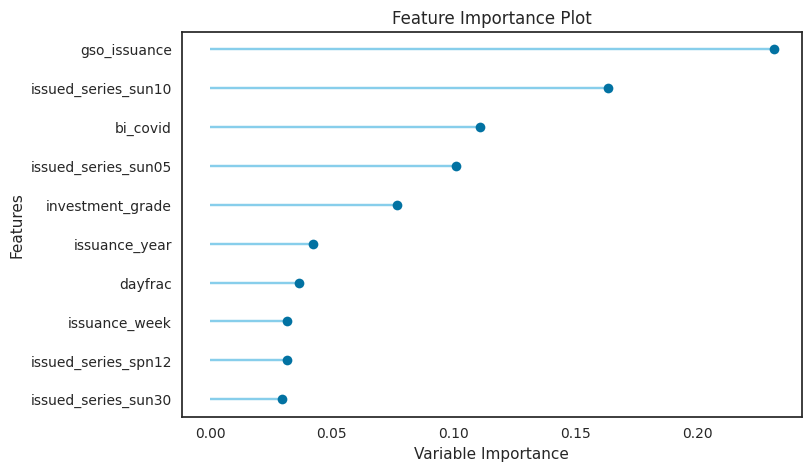

In [37]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 63.64%

In [38]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2094508.3750,9757528162304.0000,3123704.2500,0.6784,0.6061,0.6712
1,2486299.0000,12772727324672.0000,3573895.2500,0.6657,1.7136,0.8591
2,2316144.0000,9880896274432.0000,3143389.2500,0.6744,1.3343,0.6360
3,2560612.0000,17006473510912.0000,4123890.5000,0.6415,1.6208,0.7034
4,2776821.7500,17207029399552.0000,4148135.7500,0.6260,0.9376,3.1716
5,2404464.2500,10627775987712.0000,3260027.0000,0.6286,0.6193,0.6974
6,2539895.2500,16847862759424.0000,4104614.7500,0.6359,1.2013,0.7727
7,2311490.7500,13698324234240.0000,3701124.7500,0.5300,1.6089,0.5885
8,2313047.5000,12214596534272.0000,3494938.7500,0.6569,1.7829,0.6485


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.33%

In [39]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2124430.0000,9343423479808.0000,3056701.5000,0.6921,0.6250,0.6505
1,2434910.7500,11955410567168.0000,3457659.7500,0.6871,1.6713,0.8283
2,2294477.7500,10551742693376.0000,3248344.5000,0.6523,1.3507,0.6309
3,2441069.2500,13426422185984.0000,3664208.2500,0.7170,1.5941,0.6542
4,2678178.5000,15792161685504.0000,3973935.2500,0.6568,0.9120,1.8178
5,2254767.0000,9650027102208.0000,3106449.2500,0.6628,0.6616,0.7512
6,2476710.0000,15406824685568.0000,3925152.7500,0.6670,1.2602,0.8455
7,2210549.5000,13069157662720.0000,3615129.0000,0.5516,1.5369,0.5819
8,2478410.5000,12963449667584.0000,3600479.0000,0.6359,1.7492,0.6837


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

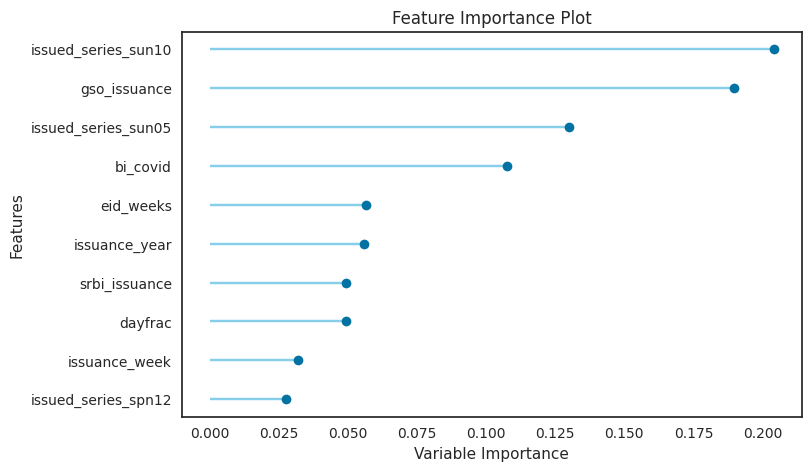

In [40]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 64.85%

In [41]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2243239.5245,10605799364208.7246,3256654.6277,0.6505,0.5782,0.5778
1,2439887.6810,12755183464570.7207,3571439.9707,0.6662,1.5119,0.7406
2,2123555.3374,9928068226984.2305,3150883.7216,0.6728,1.1021,0.4737
3,2509039.7331,15830162449053.2773,3978713.6676,0.6663,1.6373,0.6039
4,2497370.5276,15818333095483.7305,3977226.8097,0.6562,0.8170,2.0845
5,2229319.1043,9693776839820.8105,3113483.0720,0.6613,0.6172,0.6767
6,2478166.9693,13930248351761.5957,3732324.7918,0.6990,1.2443,0.6800
7,2375652.4509,13967140729953.9316,3737263.8026,0.5208,1.6575,0.5963
8,2428696.6871,11871365458406.9453,3445484.7929,0.6666,1.6669,0.6408


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 54.59%

In [42]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2582106.4370,14850486408774.0801,3853632.8845,0.5106,0.7268,0.9613
1,2840571.3016,15464070762865.9258,3932438.2720,0.5953,1.7974,1.0223
2,2617514.2620,12217955197379.8418,3495419.1733,0.5974,1.3210,0.7958
3,2860154.7084,20763102917847.2695,4556654.7947,0.5623,1.7810,0.9259
4,2932647.1590,18632271126025.3203,4316511.4532,0.5951,1.0250,5.5337
5,2675690.5759,13613178295969.8926,3689604.0839,0.5243,0.7414,0.9675
6,3188483.2607,21971478327469.9336,4687374.3532,0.5252,1.4294,1.4640
7,2517706.2305,15644965479080.0605,3955371.7245,0.4632,1.7775,0.8630
8,2765957.8364,15940664328666.1816,3992576.1519,0.5523,1.8333,0.9482


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 60.33%

In [43]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2370125.4369,13534453496963.6562,3678920.1537,0.5540,0.6667,0.7975
1,2607872.5659,13874702947408.4297,3724876.2325,0.6369,1.7356,0.9201
2,2356366.3506,10558510021138.5273,3249386.0991,0.6521,1.2737,0.7032
3,2645277.1792,18354291909959.2344,4284190.9283,0.6131,1.7032,0.7757
4,2841103.4242,18106876078062.3945,4255217.5124,0.6065,0.9961,4.0472
5,2412167.6222,11597285247122.7969,3405478.7104,0.5948,0.7060,0.8856
6,2798271.4822,18606508225981.6367,4313526.1940,0.5979,1.3734,1.2115
7,2301944.5595,13106501703333.3809,3620290.2789,0.5503,1.7385,0.6938
8,2633050.0008,14443358263558.3613,3800441.8511,0.5943,1.7733,0.8761


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 65.41%

In [44]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2175615.8233,10986891408350.9766,3314648.0067,0.6379,0.5871,0.6278
1,2460477.1797,12637437118945.6602,3554917.3153,0.6693,1.5930,0.7999
2,2104922.6474,8706161718986.7598,2950620.5651,0.7131,1.1413,0.5303
3,2521471.0716,16578341166199.8984,4071650.9141,0.6505,1.6494,0.6628
4,2557055.5226,16314323960485.6289,4039099.3997,0.6454,0.8539,2.1877
5,2242305.0048,10247974746018.5977,3201245.8116,0.6419,0.6387,0.7293
6,2485758.4603,14295601272958.8027,3780952.4293,0.6911,1.2602,0.7684
7,2240293.0188,11851393602723.2539,3442585.3080,0.5934,1.6315,0.6035
8,2439256.6787,12608894698548.3867,3550900.5475,0.6458,1.7260,0.7033


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.31%

In [45]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2226616.8221,11309374003193.9023,3362941.2726,0.6273,0.5726,0.6059
1,2440171.2393,12422805039958.7363,3524599.9830,0.6749,1.6207,0.7702
2,2187633.2069,9812193137908.4844,3132442.0406,0.6766,1.2344,0.5487
3,2475309.0890,14477051240647.0312,3804872.0400,0.6948,1.6044,0.6398
4,2541309.0861,15387625004238.6504,3922706.3367,0.6656,0.8775,2.5950
5,2166306.7812,9624149381315.0605,3102281.3189,0.6637,0.6078,0.6719
6,2468270.3834,13737115750147.6270,3706361.5245,0.7031,1.2561,0.8183
7,2168160.6135,11390580158831.6445,3374993.3569,0.6092,1.6532,0.5692
8,2474460.7271,11960379378592.4375,3458378.1428,0.6641,1.6784,0.7456


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

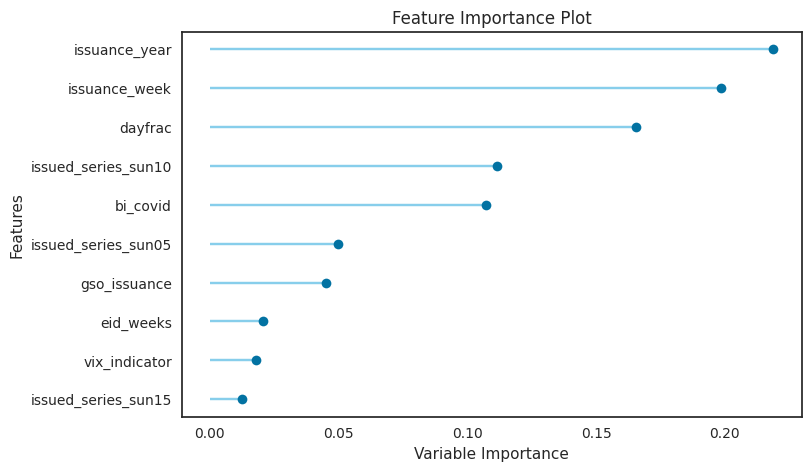

In [46]:
plot_model(et_boosted, plot = 'feature')

# Choosen

## Blended -- 61.44%

In [47]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_boosted, et_boosted], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2012433.6828,9337095860453.4180,3055666.1893,0.6923,0.7382,0.6097
1,2374847.5731,10865171362917.6621,3296235.9386,0.7157,1.6473,0.7998
2,2245292.3608,10138376683955.0391,3184081.7646,0.6659,1.3155,0.6164
3,2357295.3768,13183087081282.8027,3630852.1150,0.7221,1.5352,0.6245
4,2480935.4409,14476497670450.5879,3804799.2944,0.6854,0.8142,1.6042
5,2083961.0276,8319828866930.6133,2884411.3554,0.7093,0.5944,0.6617
6,2335850.2324,13717717122377.7969,3703743.6632,0.7035,1.1921,0.7711
7,2130120.1822,11610260581951.3535,3407383.2455,0.6016,1.5368,0.5323
8,2317389.0940,11488788552039.3281,3389511.5507,0.6773,1.7324,0.6278


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [48]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2329770.9286,11343208797831.0723,3367968.0518,0.6144,0.6142,0.6998


In [ ]:
# plot_model(blended, plot = 'residuals')

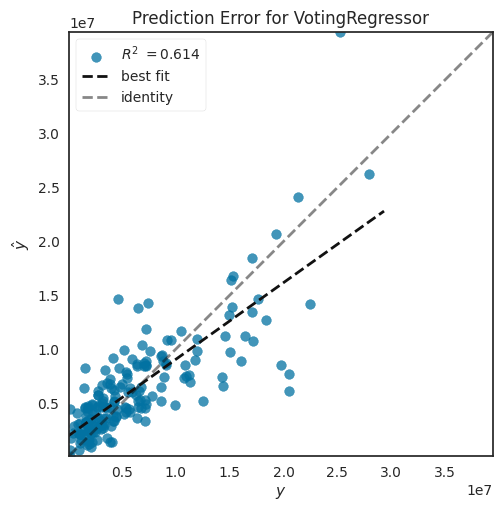

In [49]:
plot_model(blended, plot = 'error')

## Stacked -- 60.14%

In [50]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_boosted, et_boosted])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2026416.7928,9736751812406.6992,3120376.8703,0.6791,0.5958,0.6542
1,2409907.4632,11255785603729.4746,3354964.3223,0.7054,1.6313,0.7682
2,2281899.2296,10557029267151.0781,3249158.2398,0.6521,1.3071,0.6454
3,2375397.3915,13252055100652.3906,3640337.2235,0.7206,1.5114,0.6066
4,2469801.6730,14410766395504.0371,3796151.5243,0.6868,0.7912,1.3158
5,2058998.2552,8348048835916.6494,2889299.0215,0.7083,0.5936,0.6628
6,2374480.3124,13282817469436.9531,3644559.9830,0.7129,1.3189,0.7806
7,2105631.1012,11322826691835.8320,3364940.8155,0.6115,1.4927,0.5156
8,2283464.7570,11204178557726.1777,3347264.3394,0.6853,1.7144,0.6209


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2335430.8762,11727164471597.9531,3424494.7761,0.6014,0.6397,0.6610


In [ ]:
# plot_model(stacked, plot = 'residuals')

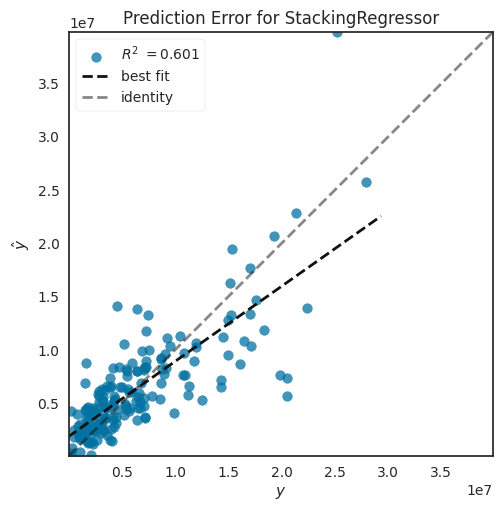

In [52]:
plot_model(stacked, plot = 'error')

## Finalizing -- 97.23%

In [53]:
final = finalize_model(blended)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,717182.3314,815713010643.7568,903168.3180,0.9723,0.3006,0.2499


In [54]:
save_model(final, '/content/drive/MyDrive/00database/20240129_blended02')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'dayfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImputer(...
                                                                                        max_leaves=None,
                                                                                        min_child_weight=None,
                                                                                        missin

# Lelang 30 Jan 2024

## Load

In [58]:
lelang20240130 = pd.read_excel('/content/drive/MyDrive/00database/dbpodem_20240130.xlsx', sheet_name='lelang20240130')
lelang20240130['issuance_date'] = pd.to_datetime(lelang20240130['issuance_date'], format='%d/%m/%Y')
lelang20240130.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     8 non-null      object        
 1   issuance_date     8 non-null      datetime64[ns]
 2   issuance_year     8 non-null      int64         
 3   issuance_week     8 non-null      int64         
 4   dayfrac           8 non-null      int64         
 5   eid_weeks         8 non-null      int64         
 6   srbi_issuance     8 non-null      int64         
 7   vix_indicator     8 non-null      int64         
 8   bi_covid          8 non-null      int64         
 9   gso_issuance      8 non-null      int64         
 10  investment_grade  8 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 832.0+ bytes


## Model: 20240129_stacked02

In [59]:
# predict model on new_data
predict03= predict_model(final, data = lelang20240130)
predict03

,issued_series,issuance_date,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-30,2024,1,92,0,1,0,0,0,1,2.501160e+06
1,spn12,2024-01-30,2024,1,352,0,1,0,0,0,1,6.905557e+06
2,sun05,2024-01-30,2024,1,1902,0,1,0,0,0,1,1.300009e+07
3,sun08,2024-01-30,2024,1,2450,0,1,0,0,0,1,4.609427e+06
4,sun10,2024-01-30,2024,1,3669,0,1,0,0,0,1,1.417256e+07
5,sun15,2024-01-30,2024,1,5250,0,1,0,0,0,1,3.649350e+06
6,sun20,2024-01-30,2024,1,7076,0,1,0,0,0,1,2.645474e+06
7,sun30,2024-01-30,2024,1,11124,0,1,0,0,0,1,4.721397e+06


In [60]:
# @title Lelang 20240130: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-30    |      2.50 trillion |
| spn12           |   2024-01-30    |      6.91 trillion |
| sun05           |   2024-01-30    |     13.00 trillion |
| sun08           |   2024-01-30    |      4.61 trillion |
| sun10           |   2024-01-30    |     14.17 trillion |
| sun15           |   2024-01-30    |      3.65 trillion |
| sun20           |   2024-01-30    |      2.65 trillion |
| sun30           |   2024-01-30    |      4.72 trillion |


In [62]:
# @title Lelang 20240130: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 61.44%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 61.44%,
the estimated incoming bid for the next issuance is approximately Rp52,205,016.21 million
or Rp52.21 trillion.



## Model: 20240129_stacked01

In [63]:
# load model
stacked01_20240129 = load_model("/content/drive/MyDrive/00database/20240129_stacked01")

# predict model on new_data
predict05 = predict_model(stacked01_20240129, data = lelang20240130)
predict05

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-30,2024,1,92,0,1,0,0,0,1,2.968278e+06
1,spn12,2024-01-30,2024,1,352,0,1,0,0,0,1,4.675696e+06
2,sun05,2024-01-30,2024,1,1902,0,1,0,0,0,1,1.209311e+07
3,sun08,2024-01-30,2024,1,2450,0,1,0,0,0,1,3.304408e+06
4,sun10,2024-01-30,2024,1,3669,0,1,0,0,0,1,1.335974e+07
5,sun15,2024-01-30,2024,1,5250,0,1,0,0,0,1,7.784497e+06
6,sun20,2024-01-30,2024,1,7076,0,1,0,0,0,1,1.689635e+06
7,sun30,2024-01-30,2024,1,11124,0,1,0,0,0,1,3.925026e+06


In [64]:
# @title Lelang 20240130: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict06 = predict05[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict06['issuance_date'] = predict06['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict06['prediction_label'] = predict06['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict06.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-30    |      2.97 trillion |
| spn12           |   2024-01-30    |      4.68 trillion |
| sun05           |   2024-01-30    |     12.09 trillion |
| sun08           |   2024-01-30    |      3.30 trillion |
| sun10           |   2024-01-30    |     13.36 trillion |
| sun15           |   2024-01-30    |      7.78 trillion |
| sun20           |   2024-01-30    |      1.69 trillion |
| sun30           |   2024-01-30    |      3.93 trillion |


In [65]:
# @title Lelang 20240130: Total

# Sum total incoming bid
incoming_bid = predict05['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 58.11%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 58.11%,
the estimated incoming bid for the next issuance is approximately Rp49,800,395.83 million
or Rp49.80 trillion.



## Model: 20240129_blended01

In [66]:
# load model
blended01_20240129 = load_model("/content/drive/MyDrive/00database/20240129_blended01")

# predict model on new_data
predict07 = predict_model(blended01_20240129, data = lelang20240130)
predict07

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,dayfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-01-30,2024,1,92,0,1,0,0,0,1,2.826153e+06
1,spn12,2024-01-30,2024,1,352,0,1,0,0,0,1,6.066159e+06
2,sun05,2024-01-30,2024,1,1902,0,1,0,0,0,1,1.098001e+07
3,sun08,2024-01-30,2024,1,2450,0,1,0,0,0,1,4.268989e+06
4,sun10,2024-01-30,2024,1,3669,0,1,0,0,0,1,1.364008e+07
5,sun15,2024-01-30,2024,1,5250,0,1,0,0,0,1,4.875544e+06
6,sun20,2024-01-30,2024,1,7076,0,1,0,0,0,1,2.598679e+06
7,sun30,2024-01-30,2024,1,11124,0,1,0,0,0,1,4.067506e+06


In [67]:
# @title Lelang 20240130: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict08 = predict07[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict08['issuance_date'] = predict08['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict08['prediction_label'] = predict08['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict08.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-01-30    |      2.83 trillion |
| spn12           |   2024-01-30    |      6.07 trillion |
| sun05           |   2024-01-30    |     10.98 trillion |
| sun08           |   2024-01-30    |      4.27 trillion |
| sun10           |   2024-01-30    |     13.64 trillion |
| sun15           |   2024-01-30    |      4.88 trillion |
| sun20           |   2024-01-30    |      2.60 trillion |
| sun30           |   2024-01-30    |      4.07 trillion |


In [69]:
# @title Lelang 20240130: Total

# Sum total incoming bid
incoming_bid = predict07['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a blended machine learning algorithm model with an R-squared value of 56.80%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a blended machine learning algorithm model with an R-squared value of 56.80%,
the estimated incoming bid for the next issuance is approximately Rp49,323,118.51 million
or Rp49.32 trillion.

